<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/LS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.optimize import minimize
from sklearn.metrics import r2_score


In [2]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the uploaded CSV file
# Replace 'cf_pair25_v1.csv' with the exact filename you uploaded
data = pd.read_csv('cf_pair25_v1.csv')

Saving cf_pair25_v1.csv to cf_pair25_v1.csv


In [9]:
# ===============================
# 0. Imports and configuration
# ===============================
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

# -------------------------------
# Config
# -------------------------------
TIME_STEP = 0.1

# ===============================
# 1. IDM model
# ===============================
def idm_model(s, v, delta_v, params, T=1.5, v0=30, s0=1):
    a, b = params
    delta = 4
    s = max(s, 0.1)  # numerical stability
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    return a * (1 - (v / v0)**delta - (s_star / s)**2)

# ===============================
# 2. Calibration function using NRMSE
# ===============================
def calibration(params, df, mop="position", time_step=TIME_STEP):
    residuals_all = []
    nrmse_list = []

    for _, data in df.groupby("Vehicle_ID_f"):
        # Initial states
        v0 = data["v_f"].iloc[0]
        x0 = data["x_f"].iloc[0]

        v_lead = data["v_l"].values
        x_lead = data["x_l"].values
        obs_v = data["v_f"].values
        obs_x = data["x_f"].values

        length_l = data["length_l"].values
        length_f = data["length_f"].values

        # Simulate trajectory
        sim_v = [v0]
        sim_x = [x0]
        sim_a = [0.0]

        for i in range(1, len(data)):
            s = x_lead[i-1] - sim_x[-1] - (length_l[i-1] + length_f[i-1]) / 2
            delta_v = sim_v[-1] - v_lead[i-1]
            acc = idm_model(s, sim_v[-1], delta_v, params)
            v_next = max(sim_v[-1] + acc * time_step, 0)
            x_next = sim_x[-1] + 0.5 * (v_next + sim_v[-1]) * time_step
            sim_v.append(v_next)
            sim_x.append(x_next)
            sim_a.append(acc)

        sim_v = np.array(sim_v)
        sim_x = np.array(sim_x)
        sim_a = np.array(sim_a)
        obs_a = np.diff(obs_v, prepend=obs_v[0]) / time_step

        if mop == "position":
            res = obs_x - sim_x
            norm = obs_x.max() - obs_x.min()
        elif mop == "speed":
            res = obs_v - sim_v
            norm = obs_v.max() - obs_v.min()
        elif mop == "acceleration":
            res = obs_a - sim_a
            norm = obs_a.max() - obs_a.min()
        else:
            raise ValueError("Invalid MOP")

        residuals_all.extend(res)
        nrmse = np.sqrt(np.mean(res**2)) / (norm if norm != 0 else 1)
        nrmse_list.append(nrmse)

    mean_nrmse = np.mean(nrmse_list)
    return np.array(residuals_all), mean_nrmse

# Wrapper for least-squares optimization
def calibration_gof(params, data, mop, number=0):
    result = calibration(params, data, mop)
    return result[number]  # number=0 for residuals (least_squares)

# ===============================
# 3. Load data
# ===============================
data = pd.read_csv("cf_pair25_v1.csv")
vehicle_ids = data["Vehicle_ID_f"].unique()
cv_ids = vehicle_ids[:-5]

# ===============================
# 4. Cross-validation
# ===============================
bounds = ([0.1, 0.1], [7.0, 7.0])
init_params = [0.7, 1.5]

for mop in ["position", "speed", "acceleration"]:
    print("\n" + "="*75)
    print(f"MOP = {mop.upper()}")
    print("="*75)

    params_ls = []
    nrmse_ls = []

    fold_id = 0
    for start in range(0, len(cv_ids), 4):
        fold_id += 1

        test_ids = cv_ids[start:start+4]
        train_ids = np.setdiff1d(vehicle_ids, test_ids)

        train_df = data[data.Vehicle_ID_f.isin(train_ids)]
        test_df  = data[data.Vehicle_ID_f.isin(test_ids)]

        # -----------------------------
        # Least Squares (minimize NRMSE via residuals)
        # -----------------------------
        p_ls = least_squares(
            calibration_gof,
            init_params,
            args=(train_df, mop, 0),
            bounds=bounds
        ).x

        params_ls.append(p_ls)

        # Compute NRMSE on test set
        nrmse_ls.append(calibration(p_ls, test_df, mop)[1])

        print(f"Fold {fold_id}: LS(a={p_ls[0]:.3f}, b={p_ls[1]:.3f}), "
              f"NRMSE={nrmse_ls[-1]:.6f}")

    params_ls = np.array(params_ls)

    print("\nMean test NRMSE over all folds:")
    print(f"  LS : {np.mean(nrmse_ls):.6f}")

    print("\nMean calibrated parameters over all folds:")
    print(f"  LS : a={params_ls[:,0].mean():.4f}, b={params_ls[:,1].mean():.4f}")

# ===============================
# End of script
# ===============================



MOP = POSITION
Fold 1: LS(a=0.412, b=0.350), NRMSE=0.006840
Fold 2: LS(a=0.357, b=0.339), NRMSE=0.006209
Fold 3: LS(a=0.389, b=0.159), NRMSE=0.004649
Fold 4: LS(a=0.386, b=0.165), NRMSE=0.006520
Fold 5: LS(a=0.364, b=0.295), NRMSE=0.005616

Mean test NRMSE over all folds:
  LS : 0.005967

Mean calibrated parameters over all folds:
  LS : a=0.3817, b=0.2617

MOP = SPEED
Fold 1: LS(a=0.756, b=1.381), NRMSE=0.092373
Fold 2: LS(a=0.719, b=1.816), NRMSE=0.083493
Fold 3: LS(a=0.664, b=1.392), NRMSE=0.058688
Fold 4: LS(a=0.676, b=1.454), NRMSE=0.068723
Fold 5: LS(a=0.702, b=1.697), NRMSE=0.069425

Mean test NRMSE over all folds:
  LS : 0.074540

Mean calibrated parameters over all folds:
  LS : a=0.7034, b=1.5480

MOP = ACCELERATION
Fold 1: LS(a=0.793, b=2.037), NRMSE=0.128127
Fold 2: LS(a=0.813, b=2.624), NRMSE=0.125955
Fold 3: LS(a=0.740, b=1.935), NRMSE=0.108707
Fold 4: LS(a=0.725, b=1.913), NRMSE=0.116786
Fold 5: LS(a=0.735, b=2.059), NRMSE=0.115354

Mean test NRMSE over all folds:
  LS 

In [4]:
data["Vehicle_ID_f"].unique()
vehicle_ids = data["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
vehicle_ids_eval=data["Vehicle_ID_f"].unique()[-5:]
vehicle_ids_crossval=data["Vehicle_ID_f"].unique()[:-5]
N_eval=len(vehicle_ids_eval)
N_crossval=len(vehicle_ids_crossval)
print([int(x) for x in vehicle_ids_eval])  #should be 12638, 10 , 9683, 3054, 5167


[12638, 10, 9683, 3054, 5167]


In [ ]:
params=[1,1.5]
result_her=log_likelihood(params, data, time_step=0.1, sigma=1.0)
print(result_her)
print("here")
results_me=calibration_gof(params, data,  False, number=2)
print(results_me)

13.61318164
-1.218608915
0.850604195164895
10.176219742075824
13.732999555924177
-1.1726334934835094
0.8437329617522848
10.613348851936236
13.848177206063763
-1.1372277503082815
0.8376837331096507
11.058885045270955
16967.030596927372
here
r


In [ ]:
#Crossvalidation
mop="speed" ## or positon or spacing
trajectories = {}
speed_curves={}
all_params_1=[]
all_params_2=[]
all_params_3=[]
test_gof = {'least_squares': [], 'minimize_gof': [], 'minimize_ll': []}


for start in range(0, N_crossval, 4):
    test_ids = vehicle_ids[start:start+4]
    train_ids = np.setdiff1d(vehicle_ids, test_ids)
    print(test_ids)

    train_df = data[data["Vehicle_ID_f"].isin(train_ids)]
    test_df  = data[data["Vehicle_ID_f"].isin(test_ids)]

    # 1. Calibration
    initial_guess = [0.7, 1.5]   # a, b typical values
    # Define bounds to ensure non-negative parameters for a, and b
    bounds_1 = ([0.1, 0.1], [7.0, 7.0])
    bounds_2 = [(0.1, 7.0), (0.1, 7.0)]


    result_1 = least_squares(calibration_gof, initial_guess, args=(train_df,mop,0), bounds=bounds_1)
    result_2 = minimize(calibration_gof, initial_guess, args=(train_df,mop,1), bounds=bounds_2, method="L-BFGS-B")
    result_3 = minimize(calibration_gof, initial_guess, args=(train_df,mop,2), bounds=bounds_2, method='L-BFGS-B')
    params_1 = result_1.x
    params_2 = result_2.x
    params_3 = result_3.x

    print(params_1)
    print(params_2)
    print(params_3)

    all_params_1.append(params_1)
    all_params_2.append(params_2)
    all_params_3.append(params_3)

    # 2. Testing (my validation uses the same calibration function- I rewrote them in such a way that it can be used for both)
    for method, params in zip(['least_squares', 'minimize_gof', 'minimize_ll'],
                              [result_1.x, result_2.x, result_3.x]):
        residuals, gof, ll,r2, trajectory, speed_curve = calibration(params, test_df, mop)
        print(r2)
        test_gof[method].append(r2)
    trajectories.update(trajectory)
    speed_curves.update(speed_curve)




mean_params_1=np.mean(np.array(all_params_1) , axis=0)
std_params_1=np.std(np.array(all_params_1) , axis=0, ddof=1)

print("Mean:",mean_params_1, "std:", std_params_1)
mean_params_2=np.mean(np.array(all_params_2) , axis=0)
std_params_2=np.std(np.array(all_params_2) , axis=0, ddof=1)

print("Mean:",mean_params_2, "std:", std_params_2)
mean_params_3=np.mean(np.array(all_params_3) , axis=0)
std_params_3=np.std(np.array(all_params_3) , axis=0, ddof=1)

print("Mean:",mean_params_3, "std:", std_params_3)

for method in test_gof:
    mean_gof = np.mean(np.array(test_gof[method]),axis=0)
    std_gof = np.std(np.array(test_gof[method]),axis=0, ddof=1)
    print("Mean:",mean_gof, "std:", std_gof)



[1939. 2740. 2933. 4189.]
[0.75593763 1.3810909 ]
[0.73843299 1.32398009]
[0.75590044 1.38093823]
[0.99874824 0.8405529 ]
[0.99875575 0.84066414]
[0.99874825 0.84055258]
[   26.  2856.    15. 12043.]
[0.71862697 1.81563498]
[0.70584487 1.84263661]
[0.71866896 1.81589013]
[0.99947343 0.85229454]
[0.99947062 0.85113102]
[0.99947343 0.85229119]
[8.8090e+03 1.2166e+04 9.0000e+00 4.0940e+03]
[0.66436586 1.39250194]
[0.64804026 1.38275232]
[0.66433482 1.39234324]
[0.99965725 0.92845544]
[0.99966071 0.92814794]
[0.99965726 0.92845533]
[10768.  1342.  6534.  2259.]
[0.67615584 1.45375625]
[0.66204301 1.44916326]
[0.67610148 1.45345953]
[0.99947585 0.92572225]
[0.99947744 0.92580312]
[0.99947585 0.92572248]
[ 4330.  3817.  5763. 10069.]
[0.70196089 1.69718781]
[0.68625    1.67142967]
[0.70197061 1.69723535]
[0.99933665 0.92344415]
[0.99933943 0.92320786]
[0.99933665 0.92344422]
Mean: [0.70340944 1.54803438] std: [0.03626307 0.19672675]
Mean: [0.68812223 1.53399239] std: [0.03583106 0.21698212]


In [ ]:
len(trajectories)

20

Evaluation set

In [ ]:
#evaluation

eval_df = data[data["Vehicle_ID_f"].isin(vehicle_ids_eval)]
residuals, gof,ll, r2,trajectories_eval, speed_curves_eval = calibration(mean_params_3, eval_df, "position")



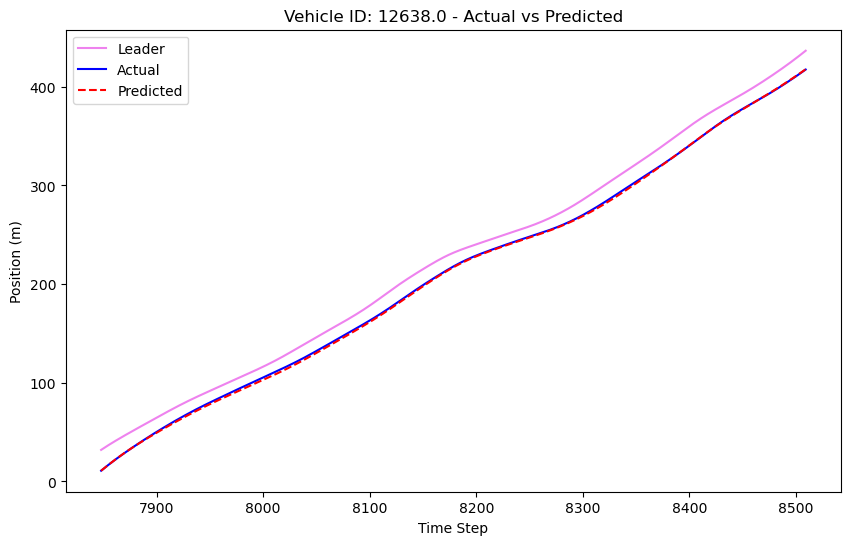

In [ ]:
import matplotlib.pyplot as plt
#vali_index, vali_index2, trajectories = calibration(calibrated_params, data)

#print("Average MSE:", vali_index2)
#plt.figure(figsize=(10, 6))
# Plot pro Fahrzeug
for vehicle_id, traj in trajectories_eval.items():
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.plot(traj["time"],traj["x_lead"], label="Leader", color="violet")
    plt.plot(traj["time"],traj["obs_x"], label="Actual", color="blue")
    plt.plot(traj["time"],traj["sim_x"], label="Predicted", color="red", linestyle="--")
    plt.xlabel("Time Step")
#plt.xlim(0,2000)
    plt.ylabel("Position (m)")
    plt.title(f"Vehicle ID: {vehicle_id} - Actual vs Predicted")
    plt.legend()
    plt.savefig(f"Plots/trajectory_{vehicle_id}_eval.png")
plt.show()


#vali_index = np.array(vali_index)
#print(np.mean(vali_index))

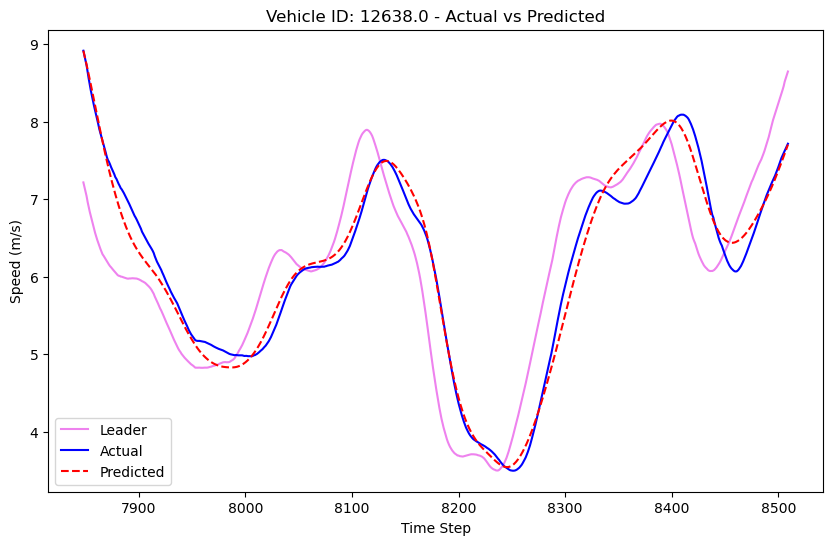

In [ ]:
import matplotlib.pyplot as plt
#vali_index, vali_index2, trajectories = calibration(calibrated_params, data)

#print("Average MSE:", vali_index2)
plt.figure(figsize=(10, 6))
# Plot pro Fahrzeug
for vehicle_id, traj in speed_curves_eval.items():
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.plot(traj["time"],traj["v_lead"], label="Leader", color="violet")
    plt.plot(traj["time"],traj["obs_v"], label="Actual", color="blue")
    plt.plot(traj["time"],traj["sim_v"], label="Predicted", color="red", linestyle="--")
    plt.xlabel("Time Step")
#plt.xlim(0,2000)
    plt.ylabel("Speed (m/s)")
    plt.title(f"Vehicle ID: {vehicle_id} - Actual vs Predicted")
    plt.legend()
    plt.savefig(f"Plots/speed_{vehicle_id}_eval.png")
plt.show()


#vali_index = np.array(vali_index)
#print(np.mean(vali_index))

789
Anderson-Darling statistic: 2.14381177849134
Critical values: [0.573 0.653 0.783 0.913 1.086]
Significance levels: [15.  10.   5.   2.5  1. ]
Reject normality at 5% level
661
Anderson-Darling statistic: 2.9029378115542386
Critical values: [0.573 0.652 0.782 0.912 1.085]
Significance levels: [15.  10.   5.   2.5  1. ]
Reject normality at 5% level
751
Anderson-Darling statistic: 5.474548878656833
Critical values: [0.573 0.653 0.783 0.913 1.086]
Significance levels: [15.  10.   5.   2.5  1. ]
Reject normality at 5% level
835
Anderson-Darling statistic: 3.382130436575153
Critical values: [0.573 0.653 0.783 0.914 1.087]
Significance levels: [15.  10.   5.   2.5  1. ]
Reject normality at 5% level
662
Anderson-Darling statistic: 3.226337525249164
Critical values: [0.573 0.652 0.782 0.913 1.086]
Significance levels: [15.  10.   5.   2.5  1. ]
Reject normality at 5% level


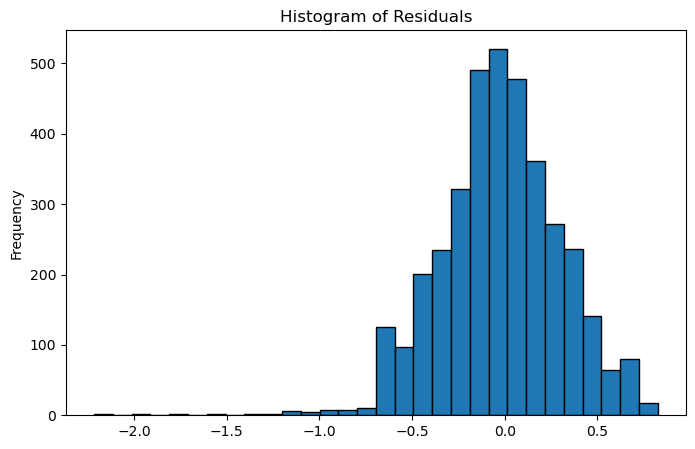

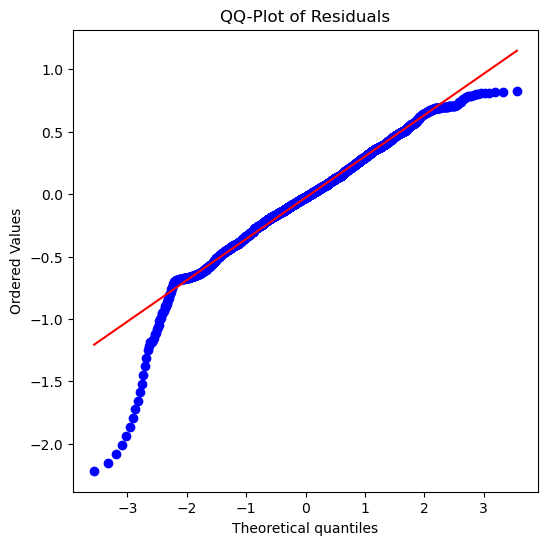

Anderson-Darling statistic: 1.9592485344010129
Critical values: [0.575 0.655 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]


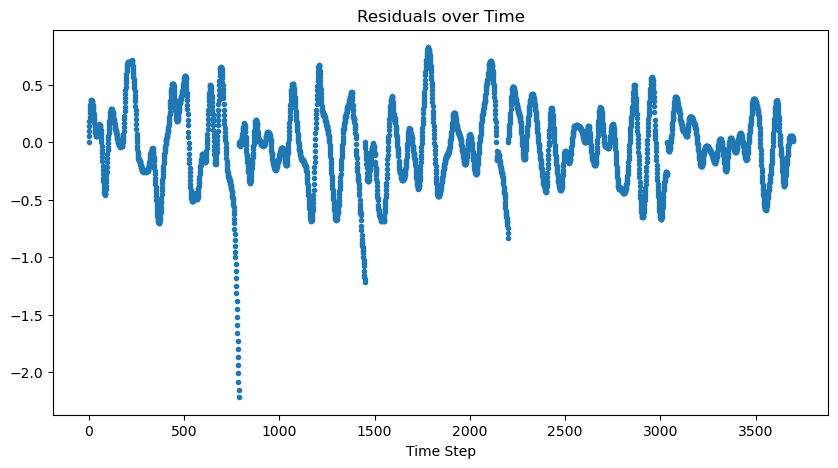

Mean residual: -0.028363435037796533
Std of residuals: 0.33529658305082327


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import anderson
# Angenommen, du hast ein Dictionary mit Fahrzeug-IDs und Trajektorien
# z.B. trajectories[vehicle_id] = {"obs_x": obs_x, "sim_x": sim_x}

all_residuals = []

for vid, traj in speed_curves_eval.items():
    obs_x = np.array(traj["obs_v"])
    sim_x = np.array(traj["sim_v"])
    residuals = obs_x - sim_x
    from scipy.stats import shapiro
    stat, p = shapiro(residuals)
    print(len(residuals))
    x = np.asarray(residuals)
    filtered = x[np.abs(x) <= 1]
    result = anderson(filtered)

    print("Anderson-Darling statistic:", result.statistic)
    print("Critical values:", result.critical_values)
    print("Significance levels:", result.significance_level)

# Beispiel: Vergleich mit 5%-Niveau
    if result.statistic > result.critical_values[2]:  # Index 2 entspricht 5%
        print("Reject normality at 5% level")
    else:
        print("Fail to reject normality at 5% level")

    all_residuals.extend(residuals)

all_residuals = np.array(all_residuals)

# 1. Histogramm der Residuen
plt.figure(figsize=(8,5))
plt.hist(all_residuals, bins=30, edgecolor='black')
plt.title("Histogram of Residuals")
#plt.xlabel("Residual (m)")
plt.ylabel("Frequency")
plt.show()

# 2. QQ-Plot (Normalverteilung prüfen)
plt.figure(figsize=(6,6))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.show()



# 3. Residuen über Zeit (optional)
plt.figure(figsize=(10,5))
plt.plot(all_residuals, marker='.', linestyle='None')
plt.title("Residuals over Time")
plt.xlabel("Time Step")
#plt.ylabel("Residual (m)")
plt.show()

# Optional: einige Kennzahlen ausgeben
print("Mean residual:", np.mean(all_residuals))
print("Std of residuals:", np.std(all_residuals))


In [ ]:
# 4. Histogram representing the distribution of the prediction error

#  YOU CODE HERE
####################################################################

# Verify if it belongs to a specific distribution

#  YOU CODE HERE
####################################################################

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data
df = pd.read_csv('cf_pair25_v1.csv')

# IDM model
def idm_model(s, v, delta_v, params, T=1.5, v0=30, s0=1):
    a, b = params
    delta = 4
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    acceleration = a * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acceleration

# Log-likelihood function
def log_likelihood(params, df, time_step=0.1, sigma=1.0):
    total_ll = 0
    grouped = df.groupby('Vehicle_ID_f')

    for vehicle_id, data in grouped:
        v_f = data['v_f'].iloc[0]
        x_f = data['x_f'].iloc[0]
        v_l = data['v_l'].values
        x_l = data['x_l'].values
        v_obs = data['v_f'].values

        v_sim = [v_f]
        x_sim = [x_f]

        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - data['length_l'].iloc[i]
            delta_v = v_sim[-1] - v_l[i]
            acc = idm_model(s, v_sim[-1], delta_v, params)


            new_v = max(v_sim[-1] + acc * time_step,0)
            new_x = x_sim[-1] + new_v * time_step
            new_x= x_sim[-1]+(new_v+v_sim[-1])/2*time_step
            if vehicle_id==3054 and i in [1,2,3]:
                print(s)
                print(delta_v)
                print(acc)
                print(new_x)
            v_sim.append(new_v)
            x_sim.append(new_x)

        # Gaussian log-likelihood
        residuals = v_obs - np.array(v_sim)
        ll = -0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma**2))
        total_ll += ll


    return -total_ll  # Negative log-likelihood for minimization

# Initial guess and bounds
initial_guess = [1.0, 2.0]
bounds = [(0.1, 5.0), (0.1, 5.0)]

# Cross-validation
trajectories = {}
speed_curves = {}
all_params = []

vehicle_ids = df["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
N_crossval = N - 5  # leave last 5 for evaluation

for start in range(0, N_crossval, 4):
    test_ids = vehicle_ids[start:start+4]
    train_ids = np.setdiff1d(vehicle_ids, test_ids)
    print("Test IDs:", test_ids)

    train_df = df[df["Vehicle_ID_f"].isin(train_ids)]
    test_df  = df[df["Vehicle_ID_f"].isin(test_ids)]

    # 1. Calibration (MLE on training set)
    result = minimize(log_likelihood, initial_guess, args=(train_df,), bounds=bounds, method='L-BFGS-B')
    params = result.x
    print("Calibrated params:", params)
    all_params.append(params)

    # 2. Testing (evaluate likelihood on test set)
    test_ll = log_likelihood(params, test_df)
    print("Test log-likelihood:", -test_ll)

    # You could also store trajectories/speed curves if you extend log_likelihood to return them

# Mean parameters across folds
mean_params = np.mean(np.array(all_params), axis=0)
print("Mean calibrated params:", mean_params)

Test IDs: [1939. 2740. 2933. 4189.]
13.61318164
-1.218608915
0.8341308153760327
10.17613737517688
13.733081922823121
-1.1742808314623954
0.8276246482215166
10.613021209671748
13.84850484832825
-1.140485919640244
0.8218777640459467
11.058152556227954
13.61318164
-1.218608915
0.8341308231709574
10.176137375215855
13.733081922784145
-1.1742808306829033
0.8276246558309104
10.61302120982672
13.848504848173281
-1.140485918099813
0.8218777714698018
11.058152556574086
13.61318164
-1.218608915
0.834130815102841
10.176137375175514
13.733081922824486
-1.1742808314897148
0.8276246479546359
10.613021209666316
13.848504848333686
-1.1404859196942523
0.8218777637842201
11.058152556215813
13.61318164
-1.218608915
0.09253657158355
10.172429403957917
13.736789894042083
-1.2484402558416443
0.09299497158826167
10.598224147631694
13.863301910368307
-1.2881083116828185
0.09354381268099297
11.024951585226816
13.61318164
-1.218608915
0.09253658010527585
10.172429404000527
13.736789893999475
-1.2484402549894709